In [1]:
import os

In [2]:
os.chdir(r'D:\subFinder')

In [3]:
## In this script we will train supervised models
# library imports
import pandas as pd
import gensim
from Codes.Supervised_Trainer import run_end_to_end
from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.multiclass import OneVsRestClassifier
import plotly.express as px

In [16]:

## read the data
# sup_data_path = r"Data/Supervised_Sequences/dbCAN-PUL_07-01-2022.xlsx"
new_path = r"D:\subFinder\Data\Supervised_Sequences\Table S1.xls"
data = pd.read_excel(new_path)
data["updated_substrate (09/01/2022)"] = data["updated_substrate (09/01/2022)"].str.strip()
data["updated_substrate (09/01/2022)"] = data["updated_substrate (09/01/2022)"].str.strip()


## removing the catch all classes
## for example multiple substrates and others 
old_data = pd.read_csv('Data/Supervised_Sequences/pul_seq_low_high_substr_year_corrected.tsv', sep = "\t")

old_data["high_level_substr"] = old_data["high_level_substr"].str.strip()

bad_puls = old_data[old_data["high_level_substr"].isin(["multiple_substrates", "mono/di/trisaccharide", "-", "human milk oligosaccharide", 
                                            "glycoprotein", "plant polysaccharide", "cellobiose"])]["PULid"].values


data = data[~data["PUL ID"].isin(bad_puls)]

data = data[["PUL ID", "updated_substrate (09/01/2022)"]]
data = pd.merge(data, old_data[["PULid","sig_gene_seq"]], left_on = ["PUL ID"], right_on = ["PULid"], how = "left")
data.columns = ["PUL ID", "high_level_substr", "PULid", "sig_gene_seq"]

data = data[~data["PUL ID"].isin(bad_puls)]


In [17]:
## read the data
# sup_data_path = r"Data/Supervised_Sequences/dbCAN-PUL_07-01-2022.xlsx"
new_sup_data_with_nulls = pd.read_csv(r"D:\subFinder\Data\Supervised_Sequences\supervised_seq_with_null.tsv", sep = "\t", 
                                      header = None)
new_sup_data_with_nulls.columns = ["PUL ID", "sequence"]

In [18]:
data = pd.merge(data, new_sup_data_with_nulls, on = ["PUL ID"], how = "left")
data = data.drop(["sig_gene_seq"],1)
data.columns = ['PUL ID', 'high_level_substr', 'PULid', 'sig_gene_seq']

C:\Users\vedpi\AppData\Local\Temp\ipykernel_13240\282975859.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = data.drop(["sig_gene_seq"],1)


In [19]:
data.to_csv(r"Data/Supervised_Sequences/updated_data_filtered.csv", index = False)

In [20]:
data["high_level_substr"].value_counts()

capsule polysaccharide synthesis      106
pectin                                 39
xylan                                  35
beta-glucan                            21
alginate                               21
host glycan                            19
cellulose                              16
starch                                 16
chitin                                 15
galactomannan                          15
glycosaminoglycan                      14
arabinan                               12
galactan                               10
alpha-mannan                            8
beta-mannan                             8
carrageenan                             8
xyloglucan                              7
fructan                                 7
arabinoxylan                            6
agarose                                 6
arabinogalactan                         5
capsule polysaccharide degradation      4
beta-galactooligosaccharide             4
glucomannan                       

In [21]:
data = data[data["high_level_substr"] != "capsule polysaccharide synthesis"]

In [86]:
data["high_level_substr"].value_counts()

pectin                                39
xylan                                 35
beta-glucan                           21
alginate                              21
host glycan                           19
cellulose                             16
starch                                16
chitin                                15
galactomannan                         15
glycosaminoglycan                     14
arabinan                              12
galactan                              10
alpha-mannan                           8
beta-mannan                            8
carrageenan                            8
xyloglucan                             7
fructan                                7
arabinoxylan                           6
agarose                                6
arabinogalactan                        5
capsule polysaccharide degradation     4
beta-galactooligosaccharide            4
glucomannan                            3
glycogen                               3
alpha-glucan    

In [22]:

# top_k = 10
K = 10
known_unknown = False


## Doc2Vec_DM model
model_dm =  gensim.models.doc2vec.Doc2Vec.load(r"Embedding_Models_10_12//doc2vec_dm") 
model_dbow = gensim.models.doc2vec.Doc2Vec.load(r"Embedding_Models_10_12//doc2vec_dbow") 
model_cbow =gensim.models.word2vec.Word2Vec.load(r"Embedding_Models_10_12//word2vec_cbow") 
model_sg =gensim.models.word2vec.Word2Vec.load(r"Embedding_Models_10_12//word2vec_sg") 
model_fasttext_sg =gensim.models.word2vec.Word2Vec.load(r"Embedding_Models_10_12//fasttext_sg") 
model_fasttext_cbow =gensim.models.word2vec.Word2Vec.load(r"Embedding_Models_10_12//fasttext_cbow") 


In [23]:
og = ["lstm_with_attention", "just_attention", "vanilla_lstm", "countvectorizer", "doc2vec_dbow", "doc2vec_dm", "word2vec_cbow", "word2vec_sg", "fasttext_sg",
                       "fasttext_cbow"]

In [24]:
overall_catch = []
for top_k in tqdm(range(2,12)):
    for featurizer in ["lstm_with_attention", "just_attention", "countvectorizer", "doc2vec_dbow", "doc2vec_dm", "word2vec_cbow", "word2vec_sg", "fasttext_sg",
                       "fasttext_cbow"]:
        print("Currently running for featurizer "+ featurizer + " with " + str(top_k) + " number of classes.")
        if featurizer == "countvectorizer":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, None)
        elif featurizer == "doc2vec_dbow":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_dbow)
        elif featurizer == "doc2vec_dm":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_dm)
        elif featurizer == "word2vec_cbow":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_cbow)            
        elif featurizer == "word2vec_sg":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_sg)
        elif featurizer == "fasttext_sg":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_fasttext_sg)      
        elif featurizer == "fasttext_cbow":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_fasttext_cbow)  
            
        elif featurizer == "lstm_with_attention": 
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_sg)
        
        elif featurizer == "just_attention": 
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_sg)        
        
        elif featurizer == "vanilla_lstm": 
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_sg)        
        
        else:
            pass
        
        overall_catch.append([top_k, featurizer, avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, 
                             overall_report["precision"], overall_report["recall"], overall_report["f1-score"]])
#         print(avg_acc, avg_class_acc)
        plt.close('all')

  0%|          | 0/10 [00:00<?, ?it/s]

Currently running for featurizer lstm_with_attention with 2 number of classes.
Currently running for featurizer just_attention with 2 number of classes.
Currently running for featurizer countvectorizer with 2 number of classes.
Currently running for featurizer doc2vec_dbow with 2 number of classes.
Currently running for featurizer doc2vec_dm with 2 number of classes.
Currently running for featurizer word2vec_cbow with 2 number of classes.
Currently running for featurizer word2vec_sg with 2 number of classes.
Currently running for featurizer fasttext_sg with 2 number of classes.
Currently running for featurizer fasttext_cbow with 2 number of classes.
Currently running for featurizer lstm_with_attention with 3 number of classes.
Currently running for featurizer just_attention with 3 number of classes.
Currently running for featurizer countvectorizer with 3 number of classes.
Currently running for featurizer doc2vec_dbow with 3 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Currently running for featurizer doc2vec_dm with 3 number of classes.
Currently running for featurizer word2vec_cbow with 3 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Currently running for featurizer word2vec_sg with 3 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Currently running for featurizer fasttext_sg with 3 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Currently running for featurizer fasttext_cbow with 3 number of classes.
Currently running for featurizer lstm_with_attention with 4 number of classes.
Currently running for featurizer just_attention with 4 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Currently running for featurizer countvectorizer with 4 number of classes.
Currently running for featurizer doc2vec_dbow with 4 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer doc2vec_dm with 4 number of classes.
Currently running for featurizer word2vec_cbow with 4 number of classes.
Currently running for featurizer word2vec_sg with 4 number of classes.
Currently running for featurizer fasttext_sg with 4 number of classes.
Currently running for featurizer fasttext_cbow with 4 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Currently running for featurizer lstm_with_attention with 5 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Currently running for featurizer just_attention with 5 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Currently running for featurizer countvectorizer with 5 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer doc2vec_dbow with 5 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Currently running for featurizer doc2vec_dm with 5 number of classes.
Currently running for featurizer word2vec_cbow with 5 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Currently running for featurizer word2vec_sg with 5 number of classes.
Currently running for featurizer fasttext_sg with 5 number of classes.
Currently running for featurizer fasttext_cbow with 5 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Currently running for featurizer lstm_with_attention with 6 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer just_attention with 6 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer countvectorizer with 6 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer doc2vec_dbow with 6 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer doc2vec_dm with 6 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer word2vec_cbow with 6 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer word2vec_sg with 6 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer fasttext_sg with 6 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer fasttext_cbow with 6 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer lstm_with_attention with 7 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer just_attention with 7 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer countvectorizer with 7 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer doc2vec_dbow with 7 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer doc2vec_dm with 7 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Currently running for featurizer word2vec_cbow with 7 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer word2vec_sg with 7 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Currently running for featurizer fasttext_sg with 7 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Currently running for featurizer fasttext_cbow with 7 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer lstm_with_attention with 8 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer just_attention with 8 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer countvectorizer with 8 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer doc2vec_dbow with 8 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer doc2vec_dm with 8 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer word2vec_cbow with 8 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer word2vec_sg with 8 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer fasttext_sg with 8 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer fasttext_cbow with 8 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer lstm_with_attention with 9 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer just_attention with 9 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer countvectorizer with 9 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer doc2vec_dbow with 9 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer doc2vec_dm with 9 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer word2vec_cbow with 9 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer word2vec_sg with 9 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer fasttext_sg with 9 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer fasttext_cbow with 9 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer lstm_with_attention with 10 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer just_attention with 10 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer countvectorizer with 10 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer doc2vec_dbow with 10 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer doc2vec_dm with 10 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer word2vec_cbow with 10 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer word2vec_sg with 10 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer fasttext_sg with 10 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer fasttext_cbow with 10 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer lstm_with_attention with 11 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer just_attention with 11 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer countvectorizer with 11 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer doc2vec_dbow with 11 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer doc2vec_dm with 11 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer word2vec_cbow with 11 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer word2vec_sg with 11 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer fasttext_sg with 11 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

Currently running for featurizer fasttext_cbow with 11 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vedpi\.conda\env

In [25]:
overall_catch = pd.DataFrame(overall_catch)

In [26]:
overall_catch.columns = ["num_substrates", "feature_method", "avg_accuracy", "avg_classwise_acc",
                         "std_err_avg_acc", "std_err_avg_classwise_acc", "avg_precision", "avg_recall", "avg_f1_score"]

In [27]:
overall_catch.head(10)

,num_substrates,feature_method,avg_accuracy,avg_classwise_acc,std_err_avg_acc,std_err_avg_classwise_acc,avg_precision,avg_recall,avg_f1_score
0,2,lstm_with_attention,0.832143,0.833333,0.154689,0.147902,0.850833,0.833333,0.827421
1,2,just_attention,0.864286,0.862500,0.085341,0.081330,0.892500,0.862500,0.859484
2,2,countvectorizer,0.876786,0.870833,0.094643,0.097628,0.893333,0.870833,0.872183
3,2,doc2vec_dbow,0.833929,0.825000,0.137871,0.148838,0.851667,0.825000,0.821627
4,2,doc2vec_dm,0.916071,0.916667,0.113516,0.110240,0.930833,0.916667,0.913413
5,2,word2vec_cbow,0.821429,0.820833,0.110368,0.108733,0.847500,0.820833,0.816230
6,2,word2vec_sg,0.889286,0.883333,0.106186,0.109924,0.901667,0.883333,0.885159
7,2,fasttext_sg,0.876786,0.870833,0.099569,0.102825,0.891667,0.870833,0.872460
8,2,fasttext_cbow,0.837500,0.837500,0.119109,0.117038,0.861667,0.837500,0.833095
9,3,lstm_with_attention,0.831111,0.838889,0.128985,0.137100,0.844603,0.838889,0.817338


In [28]:
overall_catch.to_csv(r"Data\Output\Experiments\results_by_k_new_sup_new_unsup.csv", index = False)

In [29]:
keep_the_best = overall_catch.loc[overall_catch.groupby('num_substrates')['avg_classwise_acc'].idxmax()]

In [30]:
keep_the_best

,num_substrates,feature_method,avg_accuracy,avg_classwise_acc,std_err_avg_acc,std_err_avg_classwise_acc,avg_precision,avg_recall,avg_f1_score
4,2,doc2vec_dm,0.916071,0.916667,0.113516,0.110240,0.930833,0.916667,0.913413
13,3,doc2vec_dm,0.875556,0.866667,0.099604,0.107439,0.897222,0.866667,0.858148
19,4,just_attention,0.906818,0.914583,0.095949,0.099674,0.920536,0.914583,0.906456
31,5,doc2vec_dm,0.888462,0.896667,0.076571,0.072188,0.918000,0.896667,0.886952
37,6,just_attention,0.833333,0.827778,0.108525,0.107798,0.840357,0.827778,0.814846
46,7,just_attention,0.844853,0.839286,0.079446,0.085888,0.839592,0.839286,0.816013
61,8,fasttext_sg,0.786550,0.792708,0.102289,0.093105,0.792292,0.792708,0.764206
71,9,fasttext_cbow,0.781579,0.759259,0.068482,0.072672,0.740926,0.759259,0.725996
73,10,just_attention,0.743939,0.714167,0.100597,0.089757,0.712500,0.714167,0.683738
88,11,fasttext_sg,0.695455,0.690909,0.097535,0.117158,0.677424,0.690909,0.653911


In [31]:
keep_the_best["feature_method"].value_counts()

just_attention    4
doc2vec_dm        3
fasttext_sg       2
fasttext_cbow     1
Name: feature_method, dtype: int64

In [32]:
melt_best = keep_the_best.melt(id_vars=['num_substrates'], value_vars=['avg_accuracy', 'avg_classwise_acc', "avg_precision", "avg_f1_score"])

In [ ]:
# melt_best = keep_the_best.melt(id_vars=['num_substrates'], value_vars=['avg_accuracy', 'avg_classwise_acc'])

In [33]:
melt_best.columns = ['num_substrates', 'metric_name', 'metric_value']

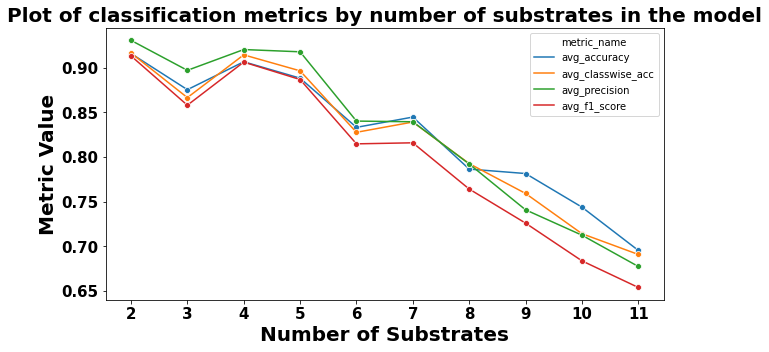

In [41]:
plt.figure(figsize = (10,5))
sns.lineplot(data=melt_best, x="num_substrates", y="metric_value", hue="metric_name",  marker="o")
plt.title("Plot of classification metrics by number of substrates in the model", fontsize = 20 ,weight = "bold")
plt.xlabel("Number of Substrates",  weight = "bold", fontsize = 20)
plt.ylabel("Metric Value", weight = "bold", fontsize = 20)
plt.xticks(range(2,12), weight = "bold", fontsize = 15)
plt.yticks(weight = "bold", fontsize = 15, rotation = 0)
plt.show()

In [42]:
overall_catch.head(30)

,num_substrates,feature_method,avg_accuracy,avg_classwise_acc,std_err_avg_acc,std_err_avg_classwise_acc,avg_precision,avg_recall,avg_f1_score
0,2,lstm_with_attention,0.832143,0.833333,0.154689,0.147902,0.850833,0.833333,0.827421
1,2,just_attention,0.864286,0.862500,0.085341,0.081330,0.892500,0.862500,0.859484
2,2,countvectorizer,0.876786,0.870833,0.094643,0.097628,0.893333,0.870833,0.872183
3,2,doc2vec_dbow,0.833929,0.825000,0.137871,0.148838,0.851667,0.825000,0.821627
4,2,doc2vec_dm,0.916071,0.916667,0.113516,0.110240,0.930833,0.916667,0.913413
5,2,word2vec_cbow,0.821429,0.820833,0.110368,0.108733,0.847500,0.820833,0.816230
6,2,word2vec_sg,0.889286,0.883333,0.106186,0.109924,0.901667,0.883333,0.885159
7,2,fasttext_sg,0.876786,0.870833,0.099569,0.102825,0.891667,0.870833,0.872460
8,2,fasttext_cbow,0.837500,0.837500,0.119109,0.117038,0.861667,0.837500,0.833095
9,3,lstm_with_attention,0.831111,0.838889,0.128985,0.137100,0.844603,0.838889,0.817338


In [22]:
# plt.figure(figsize = (20,10))
# sns.lineplot(data=overall_catch, x="num_substrates", y="avg_accuracy", hue="feature_method",  marker="o")
# plt.title("Plot of classification metrics by number of substrates in the model", fontsize = 20 ,weight = "bold")
# plt.xlabel("Number of Substrates",  weight = "bold", fontsize = 20)
# plt.ylabel("Metric Value", weight = "bold", fontsize = 20)
# plt.xticks(range(5,15), weight = "bold", fontsize = 15)
# plt.yticks(weight = "bold", fontsize = 15, rotation = 0)
# plt.show()

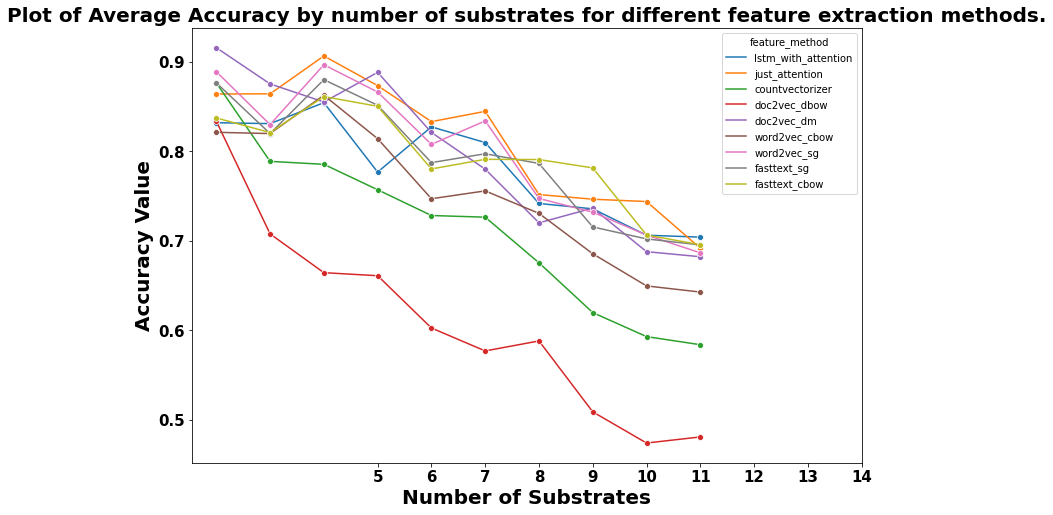

In [43]:
plt.figure(figsize = (12,8))
# filter_condn = [ "countvectorizer"]
sns.lineplot(data=overall_catch,  x="num_substrates", y="avg_accuracy", hue="feature_method",  marker="o")
plt.title("Plot of Average Accuracy by number of substrates for different feature extraction methods.", fontsize = 20 ,weight = "bold")
plt.xlabel("Number of Substrates",  weight = "bold", fontsize = 20)
plt.ylabel("Accuracy Value", weight = "bold", fontsize = 20)
plt.xticks(range(5,15), weight = "bold", fontsize = 15)
plt.yticks(weight = "bold", fontsize = 15, rotation = 0)
plt.show()

In [24]:
# K = 3

In [25]:
# overall_catch_dl = []
# for top_k in tqdm(range(5,10)):
# # for top_k in tqdm(range(9,10)):    
#     for featurizer in ["lstm_with_attention", "just_attention", "vanilla_lstm"]:
#         print("Currently running for featurizer "+ featurizer + " with " + str(top_k) + " number of classes.")
#         if featurizer == "countvectorizer":
#             avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, None)
        
#         elif featurizer == "doc2vec_dbow":
#             avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_dbow)
        
#         elif featurizer == "doc2vec_dm":
#             avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_dm)
        
#         elif featurizer == "word2vec_cbow":
#             avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_cbow)            
        
#         elif featurizer == "word2vec_sg":
#             avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_sg)
        
#         elif featurizer == "fasttext_sg":
#             avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_fasttext_sg)      
        
#         elif featurizer == "fasttext_cbow":
#             avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_fasttext_cbow)   
        
#         elif featurizer == "lstm_with_attention": 
#             avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_sg)
        
#         elif featurizer == "just_attention": 
#             avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_sg)        
        
#         elif featurizer == "vanilla_lstm": 
#             avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_sg)        
        
#         else:
#             pass
        
#         overall_catch_dl.append([top_k, featurizer, avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, 
#                              overall_report["precision"], overall_report["recall"], overall_report["f1-score"]])
        
#         plt.close('all')

In [26]:
# overall_catch_dl = pd.DataFrame(overall_catch_dl)

In [27]:
# overall_catch_dl.columns = ["num_substrates", "feature_method", "avg_accuracy", "avg_classwise_acc",
#                          "std_err_avg_acc", "std_err_avg_classwise_acc", "avg_precision", "avg_recall", "avg_f1_score"]

In [28]:
# overall_catch_dl.head(10)

In [29]:
# overall_catch_dl.to_csv(r"Data\Output\Experiments\results_by_k_deep_learners_new_sup_new_unsup.csv", index = False)

In [30]:
# keep_the_best_dl = overall_catch_dl.loc[overall_catch_dl.groupby('num_substrates')['avg_classwise_acc'].idxmax()]

In [31]:
# keep_the_best_dl

In [32]:
# melt_best_dl = keep_the_best_dl.melt(id_vars=['num_substrates'], value_vars=['avg_accuracy', 'avg_classwise_acc', "avg_precision", "avg_f1_score"])

In [33]:
# melt_best = keep_the_best.melt(id_vars=['num_substrates'], value_vars=['avg_accuracy', 'avg_classwise_acc'])

In [34]:
# melt_best_dl.columns = ['num_substrates', 'metric_name', 'metric_value']

In [35]:
# melt_best_dl

In [36]:
# plt.figure(figsize = (15,7))
# sns.lineplot(data=melt_best_dl, x="num_substrates", y="metric_value", hue="metric_name",  marker="o")
# plt.title("Plot of classification metrics by number of substrates in the model for best deep learning model", fontsize = 20 ,weight = "bold")
# plt.xlabel("Number of Substrates",  weight = "bold", fontsize = 20)
# plt.ylabel("Metric Value", weight = "bold", fontsize = 20)
# plt.xticks(range(5,10), weight = "bold", fontsize = 15)
# plt.yticks(weight = "bold", fontsize = 15, rotation = 0)
# plt.show()

In [37]:
# overall_catch_dl.head()

In [38]:
# plt.figure(figsize = (20,10))
# sns.lineplot(data=overall_catch, x="num_substrates", y="avg_accuracy", hue="feature_method",  marker="o")
# plt.title("Plot of classification metrics by number of substrates in the model", fontsize = 20 ,weight = "bold")
# plt.xlabel("Number of Substrates",  weight = "bold", fontsize = 20)
# plt.ylabel("Metric Value", weight = "bold", fontsize = 20)
# plt.xticks(range(5,15), weight = "bold", fontsize = 15)
# plt.yticks(weight = "bold", fontsize = 15, rotation = 0)
# plt.show()

In [39]:
# plt.figure(figsize = (12,8))
# # filter_condn = [ "countvectorizer"]
# sns.lineplot(data=overall_catch_dl,  x="num_substrates", y="avg_accurlacy", hue="feature_method",  marker="o")
# plt.title("Plot of Average Accuracy by number of substrates for different feature extraction methods.", fontsize = 20 ,weight = "bold")
# plt.xlabel("Number of Substrates",  weight = "bold", fontsize = 20)
# plt.ylabel("Accuracy Value", weight = "bold", fontsize = 20)
# plt.xticks(range(5,10), weight = "bold", fontsize = 15)
# plt.yticks(weight = "bold", fontsize = 15, rotation = 0)
# plt.show()

In [44]:
import pandas as pd

In [45]:
methods_and_k = pd.read_csv(r"Data\Output\Experiments\results_by_k_new_sup_new_unsup.csv")

In [46]:
methods_and_k.head()

,num_substrates,feature_method,avg_accuracy,avg_classwise_acc,std_err_avg_acc,std_err_avg_classwise_acc,avg_precision,avg_recall,avg_f1_score
0,2,lstm_with_attention,0.832143,0.833333,0.154689,0.147902,0.850833,0.833333,0.827421
1,2,just_attention,0.864286,0.862500,0.085341,0.081330,0.892500,0.862500,0.859484
2,2,countvectorizer,0.876786,0.870833,0.094643,0.097628,0.893333,0.870833,0.872183
3,2,doc2vec_dbow,0.833929,0.825000,0.137871,0.148838,0.851667,0.825000,0.821627
4,2,doc2vec_dm,0.916071,0.916667,0.113516,0.110240,0.930833,0.916667,0.913413


In [48]:
# fig.update_xaxes(title_font_family="Arial")

In [99]:
fig = px.line(methods_and_k, x="num_substrates", y="avg_accuracy", color='feature_method', 
              markers=True, 
#               title="Plot of averaged ten fold cross validation Accuracy vs Number of substrate categories", 
             labels={
                     "num_substrates": "Number of Substrate Categories",
                     "avg_accuracy": "Average Accuracy",
                     "feature_method": "Feature Extraction Method"
                 })
fig.update_traces(line=dict(width=3), marker=dict(size=8))
fig.write_html("results_by_k_new_sup_new_unsup_avg_accuracy.html")
# fig.write_image("avg_acc.png")
fig.update_yaxes(tickfont_family="Arial Black", title_font_family="Arial Black")
fig.update_xaxes(tickfont_family="Arial Black", title_font_family="Arial Black")
fig.update_layout(
    font_family="Arial Black",
#     font_color="blue",
    title_font_family="Arial Black")
#     title_font_color="red",
#     legend_title_font_color="green"
fig.show()

In [101]:
fig = px.line(methods_and_k, x="num_substrates", y="avg_classwise_acc", color='feature_method', 
              markers=True, 
#               title="Plot of averaged ten fold cross valdation Classwise Accuracy vs Number of Substrate Categories", 
             labels={
                     "num_substrates": "Number of Substrate Categories",
                     "avg_classwise_acc": "Average Classwise Accuracy",
                     "feature_method": "Feature Extraction Method"
                 })
fig.update_traces(line=dict(width=4), marker=dict(size=8))
fig.write_html("results_by_k_new_sup_new_unsup_avg_classwise_acc.html")
# fig.write_image("avg_class_acc.png")
fig.update_yaxes(tickfont_family="Arial Black", title_font_family="Arial Black")
fig.update_xaxes(tickfont_family="Arial Black", title_font_family="Arial Black")
fig.update_layout(
    font_family="Arial Black",
#     font_color="blue",
    title_font_family="Arial Black")
#     title_font_color="red",
#     legend_title_font_color="green"
fig.show()

In [52]:
keep_the_best = methods_and_k.loc[methods_and_k.groupby('num_substrates')['avg_accuracy'].idxmax()]

In [53]:
melt_best = keep_the_best.melt(id_vars=['num_substrates'], value_vars=['avg_accuracy', 'avg_classwise_acc', "avg_precision", "avg_f1_score"])

In [18]:
# melt_best = keep_the_best.melt(id_vars=['num_substrates'], value_vars=['avg_accuracy', 'avg_classwise_acc'])

In [54]:
melt_best.columns = ['num_substrates', 'metric_name', 'metric_value']

In [102]:
fig = px.line(melt_best, x="num_substrates", y="metric_value", color='metric_name', 
              markers=True, 
#               title="Plot of classification metrics for the most accurate model in each number of high level substrates category", 
             labels={
                     "num_substrates": "Number of Substrate Categories",
                     "avg_accuracy": "Average Accuracy",
                     "feature_method": "Feature Extraction Method"
                 })
fig.update_traces(line=dict(width=4), marker=dict(size=8))
fig.write_html("best_model_in_each.html")
fig.update_yaxes(tickfont_family="Arial Black", title_font_family="Arial Black")
fig.update_xaxes(tickfont_family="Arial Black", title_font_family="Arial Black")
fig.update_layout(
    font_family="Arial Black",
#     font_color="blue",
    title_font_family="Arial Black")
#     title_font_color="red",
#     legend_title_font_color="green"
fig.show()

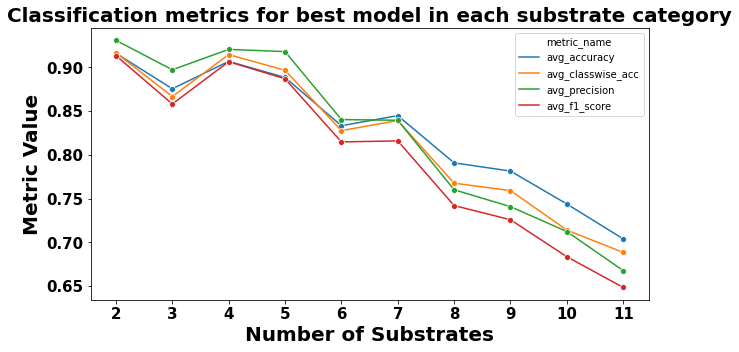

In [56]:
plt.figure(figsize = (10,5))
sns.lineplot(data=melt_best, x="num_substrates", y="metric_value", hue="metric_name",  marker="o")
plt.title("Classification metrics for best model in each substrate category", fontsize = 20 ,weight = "bold")
plt.xlabel("Number of Substrates",  weight = "bold", fontsize = 20)
plt.ylabel("Metric Value", weight = "bold", fontsize = 20)
plt.xticks(range(2,12), weight = "bold", fontsize = 15)
plt.yticks(weight = "bold", fontsize = 15, rotation = 0)
plt.show()

In [57]:
winners_podium = keep_the_best["feature_method"].value_counts().reset_index()

In [58]:
winners_podium.columns = ["Feature_Method", "Number_of_Times_Best"]

In [59]:
winners_podium

,Feature_Method,Number_of_Times_Best
0,just_attention,4
1,doc2vec_dm,3
2,fasttext_cbow,2
3,lstm_with_attention,1


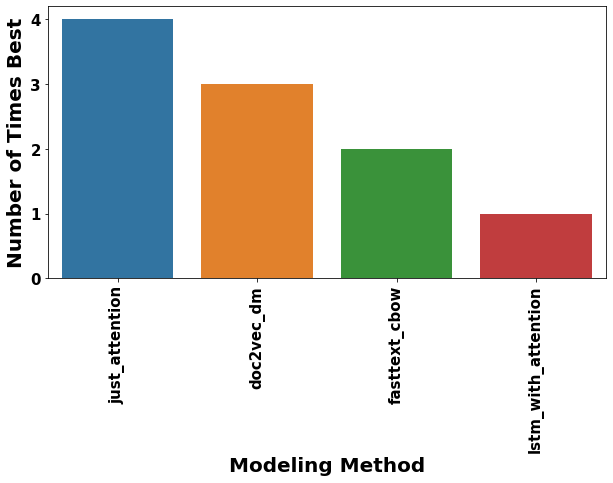

In [103]:
plt.figure(figsize = (10,5))
sns.barplot(data=winners_podium, x="Feature_Method", y="Number_of_Times_Best")
# plt.title("Count of number of times the Modeling method was the best (over the cross validation folds)", fontsize = 20 ,weight = "bold")
plt.xlabel("Modeling Method",  weight = "bold", fontsize = 20)
plt.ylabel("Number of Times Best", weight = "bold", fontsize = 20)
plt.yticks(range(0,5), weight = "bold", fontsize = 15)
plt.xticks(weight = "bold", fontsize = 15, rotation = 90)
plt.yticks(weight = "bold", fontsize = 15, rotation = 0)
plt.savefig(r"D:\subFinder\subFinder_Paper\Codes\number_best.png", 
           bbox_inches='tight')
plt.show()

In [71]:
K = 10
known_unknown = True

In [72]:
overall_catch_word2vec_sg = []
for top_k in tqdm(range(2,12)):
    for featurizer in [ "word2vec_sg"]:
        print("Currently running for featurizer "+ featurizer + " with " + str(top_k) + " number of classes.")
        if featurizer == "countvectorizer":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, None)
        elif featurizer == "doc2vec_dbow":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_dbow)
        elif featurizer == "doc2vec_dm":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_dm)
        elif featurizer == "word2vec_cbow":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_cbow)            
        elif featurizer == "word2vec_sg":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_sg)
        elif featurizer == "fasttext_sg":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_fasttext_sg)      
        elif featurizer == "fasttext_cbow":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_fasttext_cbow)  
            
        elif featurizer == "lstm_with_attention": 
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_sg)
        
        elif featurizer == "just_attention": 
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_sg)        
        
        elif featurizer == "vanilla_lstm": 
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_sg)        
        
        else:
            pass
        
        overall_catch_word2vec_sg.append([top_k, featurizer, avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, 
                             overall_report["precision"], overall_report["recall"], overall_report["f1-score"]])
        
        plt.close('all')

  0%|          | 0/10 [00:00<?, ?it/s]

Currently running for featurizer word2vec_sg with 2 number of classes.


D:\subFinder\Codes\Supervised_Trainer.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Currently running for featurizer word2vec_sg with 3 number of classes.


D:\subFinder\Codes\Supervised_Trainer.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Currently running for featurizer word2vec_sg with 4 number of classes.


D:\subFinder\Codes\Supervised_Trainer.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Pr

Currently running for featurizer word2vec_sg with 5 number of classes.


D:\subFinder\Codes\Supervised_Trainer.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Pr

Currently running for featurizer word2vec_sg with 6 number of classes.


D:\subFinder\Codes\Supervised_Trainer.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Pr

Currently running for featurizer word2vec_sg with 7 number of classes.


D:\subFinder\Codes\Supervised_Trainer.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Pr

Currently running for featurizer word2vec_sg with 8 number of classes.


D:\subFinder\Codes\Supervised_Trainer.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Pr

Currently running for featurizer word2vec_sg with 9 number of classes.


D:\subFinder\Codes\Supervised_Trainer.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Pr

Currently running for featurizer word2vec_sg with 10 number of classes.


D:\subFinder\Codes\Supervised_Trainer.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Pr

Currently running for featurizer word2vec_sg with 11 number of classes.


D:\subFinder\Codes\Supervised_Trainer.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Pr

In [73]:
overall_catch_word2vec_sg = pd.DataFrame(overall_catch_word2vec_sg)

In [ ]:
# overall_catch_word2vec_sg = pd.read_csv(r"Data\Output\Experiments\results_by_k_new_sup_new_unsup_for_word2vec_sg_with_others.csv")

In [ ]:
# overall_catch_word2vec_sg = pd.DataFrame(overall_catch_word2vec_sg)

In [74]:
overall_catch_word2vec_sg.columns = ["num_substrates", "feature_method", "avg_accuracy", "avg_classwise_acc",
                         "std_err_avg_acc", "std_err_avg_classwise_acc", "avg_precision", "avg_recall", "avg_f1_score"]

In [75]:
overall_catch_word2vec_sg["with_Others"] = "Yes"

In [76]:
overall_catch_word2vec_sg.to_csv(r"Data\Output\Experiments\results_by_k_new_sup_new_unsup_for_word2vec_sg_with_others.csv", index = False)

In [4]:
overall_catch_word2vec_sg = pd.read_csv(r"Data\Output\Experiments\results_by_k_new_sup_new_unsup_for_word2vec_sg_with_others.csv")

In [5]:
K = 10
known_unknown = False

In [78]:
overall_catch_word2vec_sg_known = []
for top_k in tqdm(range(2,12)):
    for featurizer in [ "word2vec_sg"]:
        print("Currently running for featurizer "+ featurizer + " with " + str(top_k) + " number of classes.")
        if featurizer == "countvectorizer":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, None)
        elif featurizer == "doc2vec_dbow":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_dbow)
        elif featurizer == "doc2vec_dm":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_dm)
        elif featurizer == "word2vec_cbow":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_cbow)            
        elif featurizer == "word2vec_sg":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_sg)
        elif featurizer == "fasttext_sg":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_fasttext_sg)      
        elif featurizer == "fasttext_cbow":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_fasttext_cbow)  
            
        elif featurizer == "lstm_with_attention": 
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_sg)
        
        elif featurizer == "just_attention": 
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_sg)        
        
        elif featurizer == "vanilla_lstm": 
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_sg)        
        
        else:
            pass
        
        overall_catch_word2vec_sg_known.append([top_k, featurizer, avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, 
                             overall_report["precision"], overall_report["recall"], overall_report["f1-score"]])
        
        plt.close('all')

  0%|          | 0/10 [00:00<?, ?it/s]

Currently running for featurizer word2vec_sg with 2 number of classes.
Currently running for featurizer word2vec_sg with 3 number of classes.
Currently running for featurizer word2vec_sg with 4 number of classes.
Currently running for featurizer word2vec_sg with 5 number of classes.
Currently running for featurizer word2vec_sg with 6 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in lab

Currently running for featurizer word2vec_sg with 7 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Currently running for featurizer word2vec_sg with 8 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in lab

Currently running for featurizer word2vec_sg with 9 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in lab

Currently running for featurizer word2vec_sg with 10 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in lab

Currently running for featurizer word2vec_sg with 11 number of classes.


C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\vedpi\.conda\envs\newone1\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in lab

In [79]:
# overall_catch_word2vec_sg_known = pd.read_csv(r"Data\Output\Experiments\results_by_k_new_sup_new_unsup_for_word2vec_sg_without_others.csv")

In [80]:
overall_catch_word2vec_sg_known = pd.DataFrame(overall_catch_word2vec_sg_known)

In [81]:
overall_catch_word2vec_sg_known.columns = ["num_substrates", "feature_method", "avg_accuracy", "avg_classwise_acc",
                         "std_err_avg_acc", "std_err_avg_classwise_acc", "avg_precision", "avg_recall", "avg_f1_score"]

In [82]:
overall_catch_word2vec_sg_known["with_Others"] = "No"

In [83]:
overall_catch_word2vec_sg_known.to_csv(r"Data\Output\Experiments\results_by_k_new_sup_new_unsup_for_word2vec_sg_without_others.csv", index = False)

In [6]:
overall_catch_word2vec_sg_known = pd.read_csv(r"Data\Output\Experiments\results_by_k_new_sup_new_unsup_for_word2vec_sg_without_others.csv")

In [7]:
stacked = pd.concat([overall_catch_word2vec_sg, overall_catch_word2vec_sg_known], ignore_index = True)

In [10]:
fig = px.line(stacked, x="num_substrates", y="avg_accuracy", color = "with_Others",
              markers=True, 
#               title="Avg ten fold cross validation accuracy for Word2Vec + BRF method with and without the Others category", 
             labels={
                     "num_substrates": "Number of Substrate Categories",
                     "avg_accuracy": "Average Accuracy",
                     "with_Others": "Others categories Present"
                 }, 
             title="Comparing subFinder with and without Others category")
fig.update_traces(line=dict(width=4), marker=dict(size=8))
# fig.write_html("results_by_k_new_sup_new_unsup_for_word2vec_sg.html")
fig.update_yaxes(tickfont_family="Arial Black", title_font_family="Arial Black")
fig.update_xaxes(tickfont_family="Arial Black", title_font_family="Arial Black")
fig.update_layout(
    font_family="Arial Black",
#     font_color="blue",
    title_font_family="Arial Black")

fig.write_html("With_and_Without_Others.html")
#     title_font_color="red",
#     legend_title_font_color="green"
fig.show()

In [11]:
os.getcwd()

'D:\\subFinder'